## Import packages

In [1]:
# #Run this cell to check if you have conda
# !conda --version


/bin/bash: conda: command not found


In [2]:
# #Run this cell and the following 2 cells to check packages
# import sys
# sys.path

In [3]:
# !ls /usr/local/lib/python3.7/dist-packages

In [4]:
# !ls /usr/local/lib/python3.7/site-packages

In [1]:
#Run this cell for conda colab 
!pip install -q condacolab
import condacolab
condacolab.install()
!conda --version

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:27
🔁 Restarting kernel...
conda 4.9.2


In [3]:
# #Run this cell to install necessary packages
# !conda install --channel conda-forge rioxarray --yes
# !pip install azure.storage.blob
# !pip install azure-core
# !pip install wget
# !pip install geojson
# !pip install gcsfs
# !pip install pystac_client
# !pip install planetary_computer

In [6]:
import pandas as pd
from pyproj import Proj
from pystac_client import Client
import planetary_computer
import rasterio
import geojson as gsn
# from osgeo import gdal
# from osgeo import gdalconst

import tempfile
import wget
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import pickle
from collections import defaultdict
from datetime import datetime, timedelta

import xarray as xr
import rioxarray as rxr
from azure.storage.blob import ContainerClient

import gcsfs

modis_account_name = 'modissa'
modis_container_name = 'modis-006'
modis_account_url = 'https://' + modis_account_name + '.blob.core.windows.net/'
modis_blob_root = modis_account_url + modis_container_name + '/'

# This file is provided by NASA; it indicates the lat/lon extents of each
# NOTE: this was from tutorial, not actually helpful because unprojected?

modis_tile_extents_url = modis_blob_root + 'sn_bound_10deg.txt'

temp_dir = os.path.join(tempfile.gettempdir(),'modis_snow')
os.makedirs(temp_dir,exist_ok=True)
fn = os.path.join(temp_dir,modis_tile_extents_url.split('/')[-1])
# wget.download(modis_tile_extents_url, fn)


modis_container_client = ContainerClient(account_url=modis_account_url, 
                                         container_name=modis_container_name,
                                                  credential=None)

ModuleNotFoundError: ignored

Let's clone the repository to access the data in the repo for analysis.

In [9]:
! git clone https://github.com/hanis-z/Snow-water-equivalent.git

fatal: destination path 'Snow-water-equivalent' already exists and is not an empty directory.


Below, I'm establishing my google cloud storage to save my satellite images to. 

In [48]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'snow-water-equivalent'
# !gcloud config set project {project_id}
project_name = 'Snow-Water-Equivalent'
bucket_name = 'modis-swe'

fs = gcsfs.GCSFileSystem(projectstring=project_id)
fs.ls(bucket_name)

['modis-swe/ModisSnowImagesA.npy',
 'modis-swe/ModisSnowImagesT.npy',
 'modis-swe/cell_snow_idsT.pkl']

## MODIS data

### Helper Functions

These helper functions are from a notebook example provided by [DrivenData](https://www.drivendata.org/competitions/86/competition-reclamation-snow-water-dev/page/417/) [here](https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/modis.ipynb). I also adopted the [code](https://github.com/M-Harrington/SnowComp) to load MODIS data from DrivenData user [@themrharrington](https://community.drivendata.org/u/themrharrington).

In [11]:
def lat_lon_to_modis_tile(lat,lon):
    '''converts lat lon to modis tiles but reconstructing grid and its projection'''
    
    CELLS = 2400
    VERTICAL_TILES = 18
    HORIZONTAL_TILES = 36
    EARTH_RADIUS = 6371007.181
    EARTH_WIDTH = 2 * math.pi * EARTH_RADIUS

    TILE_WIDTH = EARTH_WIDTH / HORIZONTAL_TILES
    TILE_HEIGHT = TILE_WIDTH
    CELL_SIZE = TILE_WIDTH / CELLS
    
    MODIS_GRID = Proj(f'+proj=sinu +R={EARTH_RADIUS} +nadgrids=@null +wktext')
    
    x, y = MODIS_GRID(lon, lat)
    h = (EARTH_WIDTH * .5 + x) / TILE_WIDTH
    v = -(EARTH_WIDTH * .25 + y - (VERTICAL_TILES - 0) * TILE_HEIGHT) / TILE_HEIGHT
    
    return int(h), int(v)


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_hdf_blobs_in_folder(container_name,folder_name):
    """"
    List .hdf files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.hdf')]
    return files

# daynum = '2014236'
def daynum_gen(date_time):
    '''converts date time objects to filename'''
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

In [12]:
def images_downloader(tiles, centroids, out_dataset, prod_name, verbose = False):
    """"""
    cell_ids = []
    i = 0
    for date_tile in tiles.keys():
        print("\n",i)

        date = date_tile[0]
        daynum = daynum_gen(date)
        daynum_og = daynum #to save later
        tile_num = (date_tile[1],date_tile[2])

      
        folder = prod_name + '/' + '{:0>2d}/{:0>2d}'.format(date_tile[1],date_tile[2]) + '/' + daynum

        # Find all HDF files from this tile on this day
        filenames = list_hdf_blobs_in_folder(modis_container_name,folder)
        print('Found {} matching file(s):'.format(len(filenames)))
        for fn in filenames:
            print(fn)
        file_root = filenames.copy()
        
        if len(file_root) > 1: #images may come in multiples
            print("multiple files found: ", len(file_root))
            blob_name1 = filenames[0]
            blob_name2 = filenames[1]
            
            # Download to a temporary file
            url1 = modis_blob_root + blob_name1
            url2 = modis_blob_root + blob_name2

            filename = os.path.join(temp_dir,blob_name1.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url1,filename)
                
            filename = os.path.join(temp_dir,blob_name2.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url2,filename)
            rds1 = rxr.open_rasterio(filename)
            rds2 = rxr.open_rasterio(filename)
            
            #find highest quality image
            rds1_quality = ((rds1.NDSI_Snow_Cover_Basic_QA.values >0) | (rds1.NDSI_Snow_Cover_Basic_QA.values < 2)).sum()
            rds2_quality = ((rds2.NDSI_Snow_Cover_Basic_QA.values >0) | (rds2.NDSI_Snow_Cover_Basic_QA.values < 2)).sum()
            
            rds = rds1 if rds1_quality >= rds2_quality else rds2 
                
        else:
            # Work with the first returned URL
            file_found = False
            breaker = 1
            while not file_found and breaker <= 5:
                try:
                    blob_name = filenames[0]
                    file_found = True
                except IndexError:
                    print("No file found: tile {} date {}".format(tile_num,daynum))
                    date -= timedelta(days=1)
                    daynum = daynum_gen(date) 

                    breaker +=1 
                    print("trying:", daynum)
            if breaker == 5:
                raise ValueError("Image", tile_num, daynum, "not found")


            # Download to a temporary file
            url = modis_blob_root + blob_name
            filename = os.path.join(temp_dir,blob_name.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url,filename)

            rds = rxr.open_rasterio(filename)

        #####reproject#####
        image = rds.rio.reproject(dst_crs="EPSG:4326")
        for var in image.data_vars:
            image[var]=image[var].astype(image[var].dtype,keep_attrs = False) 


        #####create blocks around centroids#####    
        cells = tiles[date_tile]
        for cell in cells:
            center = centroids[cell]


            x_idx = np.nanargmin(np.abs(image.x.values - center[0]))
            y_idx = np.nanargmin(np.abs(image.y.values - center[1]))

            #subset 21x21 square
            xmin, xmin_actual, xmax = max(x_idx -10, 0) , x_idx -10, x_idx + 11 
            ymin, ymin_actual, ymax = max(y_idx -10, 0) , y_idx -10, y_idx + 11

            sub_image = image[dict(x= slice(xmin,xmax), y= slice(ymin,ymax))]

            try: # in case we're against boundary
                sub_image = sub_image.squeeze().to_array().to_numpy()
                out_dataset[i] = sub_image
            except ValueError as e:                
                #flip and reflip before saving because coding's hard
                sub_image = np.swapaxes(sub_image, 1,2)
                
                image_shape = tuple(image.dims[d] for d in ['x', 'y'])
                simage_shape = sub_image.shape
                if verbose:
                    print(e)
                    print("Out of bounds error, padding with 0 for day/grid:", daynum_og, cell)

                    print("input shape: ", image_shape, "output shape", simage_shape)
                    print("max/min", xmax, ymax, xmin, ymin)
                    
                #pad with necessary columns
                if xmin_actual < 0:                    
                    fill = np.zeros((out_dataset.shape[1],
                                     0-xmin_actual, simage_shape[1]))
                    sub_image = np.concatenate((fill, sub_image), axis= 1)
                    simage_shape = sub_image.shape
                    if verbose:
                        print("off left")
                        print("updated simage_shape", simage_shape)
                    
                elif xmax > image_shape[0]:
                    fill = np.zeros((out_dataset.shape[1],
                                    xmax- image_shape[0], simage_shape[1]))
                    sub_image = np.concatenate((sub_image, fill), axis=1)
                    simage_shape = sub_image.shape
                    print("off right")
                    print("updated simage_shape", simage_shape)
                
                if ymin_actual < 0 :
                    fill = np.zeros((out_dataset.shape[1],
                                   21, 0-ymin_actual ))
                    sub_image = np.concatenate((fill, sub_image), axis=2)
                    simage_shape = sub_image.shape
                    if verbose:
                        print("off up")
                        print("updated simage_shape", simage_shape)

                elif ymax > image_shape[1]:
                    fill = np.zeros((out_dataset.shape[1],
                                     21, ymax - image_shape[1] ))
                    sub_image = np.concatenate((sub_image,fill), axis=2)
                    simage_shape = sub_image.shape
                    if verbose:
                        print("off down")
                        print("updated simage_shape", simage_shape)
                    
                sub_image = np.swapaxes(sub_image, 1,2)
                out_dataset[i] = sub_image
                
                
                
            cell_ids.append((cell, daynum_og)) 

            i+=1
        
        
        
    return cell_ids, out_dataset


### Ground Measures Data

In [13]:
gm_md = pd.read_csv("Snow-water-equivalent/data/ground_measures_metadata.csv")
gm_md

,station_id,name,elevation_m,latitude,longitude,state
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California
1,CDEC:AGP,Agnew Pass,2880.360000,37.726631,-119.141731,California
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California
3,CDEC:BCB,Blackcap Basin,3139.440000,37.066685,-118.773010,California
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California
...,...,...,...,...,...,...
759,SNOTEL:994_WA_SNTL,Epa Quinault Open,91.440002,46.483330,-123.966667,Washington
760,SNOTEL:995_WA_SNTL,Epa Quinault Can,91.440002,46.483330,-123.966667,Washington
761,SNOTEL:996_WA_SNTL,NWA Heather Mdws,1267.968018,48.849998,-121.666672,Washington
762,SNOTEL:998_WA_SNTL,Easy Pass,1606.296021,48.859329,-121.438950,Washington


### Cell grids

This [dataset]("../data/grid_cells.geojson") provides us spatial information about the grid cells in the submission format.

In [14]:
path = "Snow-water-equivalent/data/grid_cells.geojson"
with open(path) as f:
    gj = gsn.load(f)
print(len(gj['features']))
# gj['features']

18130


In [15]:
gj.keys()

dict_keys(['type', 'crs', 'features'])

In [16]:
gj['features'][1]

{"geometry": {"coordinates": [[[-107.076787, 37.780424], [-107.076787, 37.787523], [-107.08577, 37.787523], [-107.08577, 37.780424], [-107.076787, 37.780424]]], "type": "Polygon"}, "properties": {"cell_id": "000617d8-8c14-43e2-b708-7e3a69fe3cc3", "region": "central rockies"}, "type": "Feature"}

Let's transform our geojson data into a dataframe so its easier to look at and work with

In [17]:
grid_cell_df = pd.DataFrame.from_dict(gj['features'])
grid_cell_df['cell_id'] = [x['cell_id'] for x in grid_cell_df['properties']]
grid_cell_df['coordinates'] = [x['coordinates'][0][0:] for x in grid_cell_df['geometry']]
grid_cell_df['region'] = [x['region'] for x in grid_cell_df['properties']]
grid_cell_df = grid_cell_df.drop(['type','geometry','properties'],axis=1)
grid_cell_df

,cell_id,coordinates,region
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,"[[-118.718953, 37.074192], [-118.718953, 37.08...",sierras
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,"[[-107.076787, 37.780424], [-107.076787, 37.78...",central rockies
2,000863e7-21e6-477d-b799-f5675c348627,"[[-119.401673, 37.024005], [-119.401673, 37.03...",other
3,000ba8d9-d6d5-48da-84a2-1fa54951fae1,"[[-119.320824, 37.431707], [-119.320824, 37.43...",sierras
4,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,"[[-118.521324, 36.657353], [-118.521324, 36.66...",sierras
...,...,...,...
18125,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,"[[-118.620138, 37.117184], [-118.620138, 37.12...",sierras
18126,ffe43514-2c92-43b6-bd84-d183806aca65,"[[-123.49799, 47.901318], [-123.49799, 47.9073...",other
18127,ffeabc13-7c6f-4b63-b043-19c8f15e0345,"[[-119.644218, 37.879756], [-119.644218, 37.88...",sierras
18128,fff95195-ccc9-40b7-b302-a0d8570c86bc,"[[-123.372226, 47.732416], [-123.372226, 47.73...",other


Estimate centroids for lat_lon calculations by taking mean of points (not actual centroid because of projection and great circle distance?)

In [18]:
#test for one row
list(np.mean(grid_cell_df['coordinates'][1],axis=0))

[-107.0803802, 37.7832636]

In [19]:
#cellid : centroid
centroids = { x['cell_id']:list(np.mean(x['coordinates'],axis=0)) for index, x in grid_cell_df.iterrows()}
centroids

{'0003f387-71c4-48f6-b2b0-d853bd4f0aba': [-118.72254619999998,
  37.077058799999996],
 '000617d8-8c14-43e2-b708-7e3a69fe3cc3': [-107.0803802, 37.7832636],
 '000863e7-21e6-477d-b799-f5675c348627': [-119.4052662, 37.0268738],
 '000ba8d9-d6d5-48da-84a2-1fa54951fae1': [-119.32441759999999, 37.4345602],
 '00146204-d4e9-4cd8-8f86-d1ef133c5b6d': [-118.5249172, 36.660235799999995],
 '0017d1c4-64cb-426d-9158-3f6521d2dd22': [-119.4322152, 37.2417204],
 '0020c632-3d5c-4509-b4ee-6b63a89bf2ff': [-118.90220920000002, 36.8545572],
 '00211c19-7ea8-4f21-a2de-1d6216186a96': [-106.9456332, 38.742496800000005],
 '0021411f-e7b5-48d7-9d36-abecbc255821': [-123.3129372, 47.9879678],
 '00226e82-e747-4f03-9c5d-3eef8ebe515e': [-120.0520532, 38.003026199999994],
 '0027a004-df14-4d66-a3e4-e987336b8814': [-106.80190259999999, 38.8824902],
 '002ccd85-65b3-4903-8725-4590d1f5611e': [-123.96870759999999, 47.6078018],
 '002cec08-f455-4e8c-8682-4d69861f4120': [-119.4232322, 37.8329446],
 '0036f966-3430-45f3-b6a2-803e678a

In [20]:
len(centroids)

18130

### Training data

#### Ground measures of Training data

Below is the ground measures from  for our training data from SNOTEL and CDEC sites.

In [21]:
gm_train_feat = pd.read_csv("Snow-water-equivalent/data/ground_measures_train_features.csv")
gm_train_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,NaN,NaN,NaN,NaN,NaN,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,0.00,0.60,0.20,NaN,NaN
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.52,20.81,8.71,0.30,0.00,5.69,8.04,10.74,12.67,12.57
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.84,0.60,0.36,0.36,0.24,2.88,4.56,4.68,5.04,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.00,0.00,0.00,0.00,0.00,0.30,0.20,1.60,2.80,3.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.00,0.10,0.00,0.00,0.00,1.00,0.90,2.30,8.70,8.60
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,2.00,2.20,3.50,3.60,3.80
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.60,36.10,31.30,8.50,0.00,8.00,9.00,13.20,23.70,25.00


#### Train Labels

In [22]:
y_train = pd.read_csv("Snow-water-equivalent/data/train_labels.csv")
y_train

,cell_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-06-13,2019-06-14,2019-06-18,2019-06-24,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000ba8d9-d6d5-48da-84a2-1fa54951fae1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0017d1c4-64cb-426d-9158-3f6521d2dd22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0020c632-3d5c-4509-b4ee-6b63a89bf2ff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10873,ffdc53d2-5565-496a-b849-4fcf33f33a36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10874,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10875,ffe43514-2c92-43b6-bd84-d183806aca65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10876,fff95195-ccc9-40b7-b302-a0d8570c86bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
y_train_melt = y_train.melt(id_vars=["cell_id"]).dropna()
y_train_melt.rename(columns={"variable":'date'},inplace=True)
y_train_grouped = y_train_melt.groupby('cell_id')

#grab date/cell_id combos
#cell_id : [dates]
dates = {key:(list(group['date'])) for key, group in y_train_grouped}

In [24]:
len(y_train_melt)

91490

Even after dropping nulls, we still have 91490 training labels to work use as ground truth. Now let's compile overlapping tiles.

In [39]:
# create dictionary tiles (date, lat, lon) : [cell_ids]
counter = 0 
tiles_training = defaultdict(list)
for cell, date_list in dates.items():
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles_training[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter += 1
print("total squares:", counter)
print("Now saving tiles dictionary as .json...") 

# #Save this counter and tiles dictionary as json   
# to_save = {'Counter':counter,'tiles':tiles_training}
# output_path = f"{bucket_name}/tiles_training.json"
# with fs.open(output_path, 'wb') as handle:
#   json.dump(handle,to_save)

# print("Saving completed")


total squares: 91490
Now saving tiles dictionary as .json...


NameError: ignored

#### Load Modis Terra Training images (morning)

In [32]:
## Testing cell
# import gcsfs

# project_name = 'Snow-Water-Equivalent'
# bucket_name = 'modis-swe'

# fs = gcsfs.GCSFileSystem(projectstring=project_id)
# fs.ls(bucket_name)


# test_np = np.random.rand(3,4,2)
# output_path = f"{bucket_name}/test.npy"
# with fs.open(output_path, 'wb') as handle:
#   np.save(handle,test_np)


# path_ids = "{}/test.pkl".format(bucket_name)
# with fs.open(path_ids, 'wb') as handle:
#     pickle.dump(dates, handle)

In [42]:
product = 'MOD10A1' # Terra -morning
# product = 'MCD43A4'

#initialize empty array
dataset_t = np.empty((counter, 7, 21, 21)) #(image, band, row, column)
    
# download dataset
cell_ids, dataset_t = images_downloader(tiles_training, centroids, dataset_t, product)
    
#####save output#####
output_path = f"{bucket_name}/ModisSnowImagesT.npy"
with fs.open(output_path, 'wb') as handle:
  np.save(handle,dataset_t)

path_ids = f"{bucket_name}/cell_snow_idsT.pkl"
with fs.open(path_ids, 'wb') as handle:
  pickle.dump(cell_ids, handle)



 0
Found 1 matching file(s):
MOD10A1/08/05/2018116/MOD10A1.A2018116.h08v05.006.2018118031402.hdf

 1468
Found 1 matching file(s):
MOD10A1/08/05/2019075/MOD10A1.A2019075.h08v05.006.2019077031831.hdf

 2937
Found 1 matching file(s):
MOD10A1/08/05/2019108/MOD10A1.A2019108.h08v05.006.2019110033147.hdf

 4406
Found 1 matching file(s):
MOD10A1/08/05/2019118/MOD10A1.A2019118.h08v05.006.2019120033847.hdf

 5875
Found 1 matching file(s):
MOD10A1/08/05/2019159/MOD10A1.A2019159.h08v05.006.2019161025247.hdf

 6740
Found 1 matching file(s):
MOD10A1/09/05/2016094/MOD10A1.A2016094.h09v05.006.2016104070530.hdf

 7910
Found 1 matching file(s):
MOD10A1/08/05/2018063/MOD10A1.A2018063.h08v05.006.2018065091856.hdf

 8503
Found 1 matching file(s):
MOD10A1/08/05/2018112/MOD10A1.A2018112.h08v05.006.2018114031316.hdf

 9110
Found 1 matching file(s):
MOD10A1/08/05/2018152/MOD10A1.A2018152.h08v05.006.2018154033710.hdf

 10111
Found 1 matching file(s):
MOD10A1/08/05/2019074/MOD10A1.A2019074.h08v05.006.2019076031

In [84]:
cell_ids

[('0003f387-71c4-48f6-b2b0-d853bd4f0aba', '2018116'),
 ('0020c632-3d5c-4509-b4ee-6b63a89bf2ff', '2018116'),
 ('00559e5b-310a-4514-8123-2a3074828d74', '2018116'),
 ('00748c91-2e34-44ea-ab63-51c10bf77497', '2018116'),
 ('0095cd70-ad71-485a-a670-64fc5604db98', '2018116'),
 ('00b78996-1639-40d2-a943-2126ec4ef2e1', '2018116'),
 ('00c0b91c-9aa7-4d9b-a44f-abb91acd49d2', '2018116'),
 ('0158d4f1-037e-421a-aeed-58db7a086512', '2018116'),
 ('01724a51-925e-4d33-879f-837f436383b4', '2018116'),
 ('01867838-b8c1-45b2-bf01-a262d18c95ec', '2018116'),
 ('01909e72-97ba-4c53-85d6-15d4410a6b57', '2018116'),
 ('01a0f55a-2c5e-4539-8c74-7d315031b51f', '2018116'),
 ('01a191f1-2d34-4886-a72f-53e3c24f7356', '2018116'),
 ('01b0d56b-f1d2-436d-a0ae-bc605eede64a', '2018116'),
 ('01ccdf49-83ed-470f-8d82-3c89973bbb8c', '2018116'),
 ('01ee5268-f209-420e-a888-59ac08261065', '2018116'),
 ('01f9c9c0-d9a6-416b-96fe-2c43d250517b', '2018116'),
 ('020d17b2-4720-4c0b-b876-20aa707bf4c2', '2018116'),
 ('0266d61d-71e0-4ebc-895d-a

In [43]:
len(cell_ids)

91490

In [85]:
dataset_t.shape

(91490, 7, 21, 21)

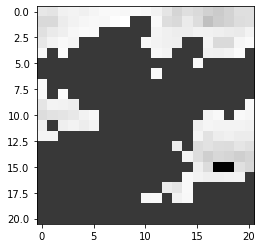

In [44]:
plt.imshow(dataset_t[1000,4,:,:],cmap='Greys')

In [45]:
dataset_t[1000,4,:,:].mean()


93.70521541950113

In [46]:
dataset_t[1000,4,0,:]

array([36., 38., 28., 26., 29., 23., 19., 18., 21., 17., 20., 27., 37.,
       49., 42., 45., 51., 55., 50., 42., 42.])

#### Load MODIS Aqua training images (afternoon)

In [47]:
product = 'MYD10A1' # Aqua -afternoon

#initialize empty array
dataset_a = np.empty((counter, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids, dataset_a = images_downloader(tiles_training, centroids, dataset_a, product)
    

#####save output#####
output_path = f"{bucket_name}/ModisSnowImagesA.npy"
with fs.open(output_path, 'wb') as handle:
  np.save(handle,dataset_a)

path_ids = f"{bucket_name}/cell_snow_idsA.pkl"
with fs.open(path_ids, 'wb') as handle:
  pickle.dump(cell_ids, handle)


 0
Found 1 matching file(s):
MYD10A1/08/05/2018116/MYD10A1.A2018116.h08v05.006.2018118031436.hdf

 1468
Found 1 matching file(s):
MYD10A1/08/05/2019075/MYD10A1.A2019075.h08v05.006.2019079193507.hdf

 2937
Found 1 matching file(s):
MYD10A1/08/05/2019108/MYD10A1.A2019108.h08v05.006.2019110032220.hdf

 4406
Found 1 matching file(s):
MYD10A1/08/05/2019118/MYD10A1.A2019118.h08v05.006.2019120031417.hdf

 5875
Found 1 matching file(s):
MYD10A1/08/05/2019159/MYD10A1.A2019159.h08v05.006.2019161033901.hdf

 6740
Found 1 matching file(s):
MYD10A1/09/05/2016094/MYD10A1.A2016094.h09v05.006.2016096071259.hdf

 7910
Found 1 matching file(s):
MYD10A1/08/05/2018063/MYD10A1.A2018063.h08v05.006.2018065092827.hdf

 8503
Found 1 matching file(s):
MYD10A1/08/05/2018112/MYD10A1.A2018112.h08v05.006.2018114031106.hdf

 9110
Found 1 matching file(s):
MYD10A1/08/05/2018152/MYD10A1.A2018152.h08v05.006.2018154033800.hdf

 10111
Found 1 matching file(s):
MYD10A1/08/05/2019074/MYD10A1.A2019074.h08v05.006.2019076025

FileNotFoundError: ignored

In [51]:
#####save output#####
output_path = f"{bucket_name}/ModisSnowImagesA.npy"
with fs.open(output_path, 'wb') as handle:
  np.save(handle,dataset_a)

path_ids = f"{bucket_name}/cell_snow_idsA.pkl"
with fs.open(path_ids, 'wb') as handle:
  pickle.dump(cell_ids, handle)

### Testing Data

#### Ground measures of testing data

The dataset below is the ground truth data for our testing data. This will be reserved to test our model performance on unseen data.

In [52]:
gm_test_feat = pd.read_csv("Snow-water-equivalent/data/ground_measures_test_features.csv")
gm_test_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_test_feat

,station_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,CDEC:ADM,4.50,5.50,7.30,8.30,8.10,8.20,9.30,8.50,7.90,...,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDEC:AGP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDEC:ALP,12.72,13.78,17.12,18.07,18.17,18.38,17.71,16.05,14.62,...,3.34,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00
3,CDEC:BCB,12.20,12.20,13.30,13.35,12.85,12.72,12.72,12.80,13.16,...,15.44,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25
4,CDEC:BCH,6.60,5.76,5.16,7.68,4.68,1.32,0.84,0.84,0.24,...,0.12,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,6.80,12.50,13.10,14.40,16.30,19.10,19.80,19.80,19.70,...,6.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
696,SNOTEL:990_WA_SNTL,13.80,17.00,20.30,24.90,26.70,29.40,29.80,31.10,32.60,...,41.20,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00
697,SNOTEL:992_UT_SNTL,4.40,5.00,5.80,6.20,6.30,6.80,7.20,7.40,7.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
698,SNOTEL:998_WA_SNTL,37.90,47.00,51.80,61.90,69.00,73.40,77.30,81.40,83.60,...,96.00,95.10,95.50,94.20,94.20,NaN,75.10,70.40,58.70,35.10


#### Testing labels

In [53]:
y_test = pd.read_csv("Snow-water-equivalent/data/labels_2020_2021.csv")
y_test

,cell_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,000863e7-21e6-477d-b799-f5675c348627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000ba8d9-d6d5-48da-84a2-1fa54951fae1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00211c19-7ea8-4f21-a2de-1d6216186a96,NaN,NaN,NaN,NaN,NaN,4.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00226e82-e747-4f03-9c5d-3eef8ebe515e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9061,ffcc02b0-5185-4f6a-bdfd-1ae1b6c68e99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.3,NaN,NaN,NaN,NaN,NaN,NaN
9062,ffce8731-d78f-4c06-ace2-7029b611f1ba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9063,ffd1aa25-27a5-4b28-abb6-e6577d1575be,NaN,NaN,NaN,NaN,NaN,11.3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9064,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
y_test_melt = y_test.melt(id_vars=["cell_id"]).dropna()
y_test_melt.rename(columns={"variable":'date'},inplace=True)
len(y_test_melt)

45241

In [55]:
y_test_melt = y_test.melt(id_vars=["cell_id"]).dropna()
y_test_melt.rename(columns={"variable":'date'},inplace=True)
y_test_grouped = y_test_melt.groupby('cell_id')

#grab date/cell_id combos
#cell_id : [dates]
dates_sub = {key:(list(group['date'])) for key, group in y_test_grouped}
dates_sub

{'000863e7-21e6-477d-b799-f5675c348627': ['2020-05-26',
  '2020-06-09',
  '2021-02-23',
  '2021-03-30',
  '2021-05-04'],
 '000ba8d9-d6d5-48da-84a2-1fa54951fae1': ['2020-04-14',
  '2020-05-05',
  '2020-05-26',
  '2020-06-09',
  '2021-02-23',
  '2021-03-30',
  '2021-05-04'],
 '00146204-d4e9-4cd8-8f86-d1ef133c5b6d': ['2020-04-14',
  '2020-05-05',
  '2020-05-26',
  '2021-03-30',
  '2021-05-04'],
 '00211c19-7ea8-4f21-a2de-1d6216186a96': ['2020-02-11'],
 '00226e82-e747-4f03-9c5d-3eef8ebe515e': ['2021-02-23', '2021-04-27'],
 '0027a004-df14-4d66-a3e4-e987336b8814': ['2020-02-11'],
 '003bc010-4187-4fba-9c3c-29ca50b15a78': ['2021-04-20', '2021-05-04'],
 '003ccf34-6c35-4546-b8c5-b926fbe5ffbb': ['2020-02-04', '2020-02-11'],
 '003d08c8-fcf3-406c-a2e2-e67f1553f767': ['2021-04-20', '2021-05-18'],
 '003fdfbd-c766-4312-b029-bd4cfba6ebef': ['2021-04-20', '2021-05-18'],
 '004389c3-b0c8-47ef-9851-df1f74c5ecda': ['2020-02-11'],
 '0043c28e-7f7d-49e9-8be3-139f93b281a7': ['2021-04-20', '2021-05-11'],
 '005ad9

In [56]:
# create dictionary tiles_test (date, lat, lon) : [cell_ids]
counter_test = 0 
tiles_test = defaultdict(list)
for cell, date_list in dates_sub.items():
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles_test[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter_test += 1
print("total squares:", counter_test)   

# print("Now saving tiles dictionary as .json...") 

# #Save this counter and tiles dictionary as json   
# to_save = {'Counter':counter_test,'tiles':tiles_test}
# output_path = f"{bucket_name}/tiles_test.json"
# with fs.open(output_path, 'wb') as handle:
#   json.dump(handle,to_save)

# print("Saving completed")

total squares: 45241


#### Load MODIS Terra Test images (Morning)

In [57]:
product = 'MOD10A1'

#initialize empty array
dataset_test_t = np.empty((counter_test, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids_sub, dataset_test_t = images_downloader(tiles_test, centroids, dataset_test_t, product)
    
#####save output#####
output_path = f"{bucket_name}/ModisSnowImages_testT.npy"
with fs.open(output_path, 'wb') as handle:
  np.save(handle,dataset_test_t)

path_ids = f"{bucket_name}/cell_snow_ids_testT.pkl"
with fs.open(path_ids, 'wb') as handle:
  pickle.dump(cell_ids_sub, handle)


 0
Found 1 matching file(s):
MOD10A1/08/05/2020147/MOD10A1.A2020147.h08v05.006.2020149034404.hdf

 3222
Found 1 matching file(s):
MOD10A1/08/05/2020161/MOD10A1.A2020161.h08v05.006.2020163033904.hdf

 5007
Found 1 matching file(s):
MOD10A1/08/05/2021054/MOD10A1.A2021054.h08v05.006.2021056040748.hdf

 8040
Found 1 matching file(s):
MOD10A1/08/05/2021089/MOD10A1.A2021089.h08v05.006.2021091041837.hdf

 11593
Found 1 matching file(s):
MOD10A1/08/05/2021124/MOD10A1.A2021124.h08v05.006.2021126054506.hdf

 15746
Found 1 matching file(s):
MOD10A1/08/05/2020105/MOD10A1.A2020105.h08v05.006.2020107033656.hdf

 19781
Found 1 matching file(s):
MOD10A1/08/05/2020126/MOD10A1.A2020126.h08v05.006.2020128033505.hdf

 23704
Found 1 matching file(s):
MOD10A1/09/05/2020042/MOD10A1.A2020042.h09v05.006.2020044034034.hdf

 24306
Found 1 matching file(s):
MOD10A1/08/05/2021117/MOD10A1.A2021117.h08v05.006.2021119220331.hdf

 26249
Found 1 matching file(s):
MOD10A1/08/05/2021110/MOD10A1.A2021110.h08v05.006.20211

#### Load MODIS Aqua Test images (Afternoon)

In [58]:
product = 'MYD10A1'

#initialize empty array
dataset_test_a = np.empty((counter_test, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids_sub, dataset_test_a = images_downloader(tiles_test, centroids, dataset_test_a, product)
    
#####save output#####
output_path = f"{bucket_name}/ModisSnowImages_testA.npy"
with fs.open(output_path, 'wb') as handle:
  np.save(handle,dataset_test_a)

path_ids = f"{bucket_name}/cell_snow_ids_testA.pkl"
with fs.open(path_ids, 'wb') as handle:
  pickle.dump(cell_ids_sub, handle)


 0
Found 1 matching file(s):
MYD10A1/08/05/2020147/MYD10A1.A2020147.h08v05.006.2020149033856.hdf

 3222
Found 1 matching file(s):
MYD10A1/08/05/2020161/MYD10A1.A2020161.h08v05.006.2020163035410.hdf

 5007
Found 1 matching file(s):
MYD10A1/08/05/2021054/MYD10A1.A2021054.h08v05.006.2021056034727.hdf

 8040
Found 1 matching file(s):
MYD10A1/08/05/2021089/MYD10A1.A2021089.h08v05.006.2021091042441.hdf

 11593
Found 1 matching file(s):
MYD10A1/08/05/2021124/MYD10A1.A2021124.h08v05.006.2021126053030.hdf

 15746
Found 1 matching file(s):
MYD10A1/08/05/2020105/MYD10A1.A2020105.h08v05.006.2020107033414.hdf

 19781
Found 1 matching file(s):
MYD10A1/08/05/2020126/MYD10A1.A2020126.h08v05.006.2020128031201.hdf

 23704
Found 1 matching file(s):
MYD10A1/09/05/2020042/MYD10A1.A2020042.h09v05.006.2020044033256.hdf

 24306
Found 1 matching file(s):
MYD10A1/08/05/2021117/MYD10A1.A2021117.h08v05.006.2021120032451.hdf

 26249
Found 1 matching file(s):
MYD10A1/08/05/2021110/MYD10A1.A2021110.h08v05.006.20211

# Corpenicus DEM

### Training data

In [89]:
centroids

{'0003f387-71c4-48f6-b2b0-d853bd4f0aba': [-118.72254619999998,
  37.077058799999996],
 '000617d8-8c14-43e2-b708-7e3a69fe3cc3': [-107.0803802, 37.7832636],
 '000863e7-21e6-477d-b799-f5675c348627': [-119.4052662, 37.0268738],
 '000ba8d9-d6d5-48da-84a2-1fa54951fae1': [-119.32441759999999, 37.4345602],
 '00146204-d4e9-4cd8-8f86-d1ef133c5b6d': [-118.5249172, 36.660235799999995],
 '0017d1c4-64cb-426d-9158-3f6521d2dd22': [-119.4322152, 37.2417204],
 '0020c632-3d5c-4509-b4ee-6b63a89bf2ff': [-118.90220920000002, 36.8545572],
 '00211c19-7ea8-4f21-a2de-1d6216186a96': [-106.9456332, 38.742496800000005],
 '0021411f-e7b5-48d7-9d36-abecbc255821': [-123.3129372, 47.9879678],
 '00226e82-e747-4f03-9c5d-3eef8ebe515e': [-120.0520532, 38.003026199999994],
 '0027a004-df14-4d66-a3e4-e987336b8814': [-106.80190259999999, 38.8824902],
 '002ccd85-65b3-4903-8725-4590d1f5611e': [-123.96870759999999, 47.6078018],
 '002cec08-f455-4e8c-8682-4d69861f4120': [-119.4232322, 37.8329446],
 '0036f966-3430-45f3-b6a2-803e678a

     |████████████████████████████████| 137 kB 4.8 MB/s 


In [ ]:
def download_DEM(centroids):
  client = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    ignore_conformance=True,
  )

  #Perform a STAC API query against the finer resolution cop-dem-glo-30.
  cell1 = centroids['0cc75027-c5f1-4868-9a17-e566c07171d4']
  search = client.search(
      collections=["cop-dem-glo-30"],
      intersects={"type": "Point", "coordinates": cell1},
  )
  items = list(search.get_items())
  # print(f"Returned {len(items)} items")
  signed_asset = planetary_computer.sign(items[0].assets["data"])

  #Open raster file
  with rasterio.open(signed_asset.href, 'r') as ds:
    arr = ds.read()  # read all raster values

  #Save to our array

In [65]:


client = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    ignore_conformance=True,
)

In [90]:
cell1 = centroids['0cc75027-c5f1-4868-9a17-e566c07171d4']
search = client.search(
    collections=["cop-dem-glo-30"],
    intersects={"type": "Point", "coordinates": cell1},
)
items = list(search.get_items())
print(f"Returned {len(items)} items")

Returned 1 items


In [91]:
print(items[0].assets)

{'data': <Asset href=https://elevationeuwest.blob.core.windows.net/copernicus-dem/COP30_hh/Copernicus_DSM_COG_10_N38_00_W121_00_DEM.tif>, 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=cop-dem-glo-30&item=Copernicus_DSM_COG_10_N38_00_W121_00_DEM&assets=data&colormap_name=terrain&rescale=-1000,4000>, 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=cop-dem-glo-30&item=Copernicus_DSM_COG_10_N38_00_W121_00_DEM&assets=data&colormap_name=terrain&rescale=-1000,4000>}


In [92]:


signed_asset = planetary_computer.sign(items[0].assets["data"])
data = (
    xarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 5, "x": 5})
    .mean()
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  


In [93]:


with rasterio.open(signed_asset.href, 'r') as ds:
    arr = ds.read()  # read all raster values

print(arr.shape)  # this is a 3D numpy array, with dimensions [band, row, col]

(1, 3600, 3600)


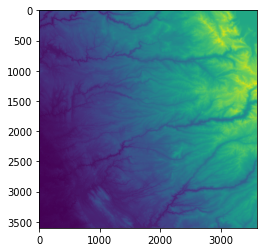

In [94]:
plt.imshow(arr[0,:,:])

In [88]:
arr[0,:,:].mean()

2364.2617

### Test data